In [33]:
import cv2
import time
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Load data from the CSV file into a DataFrame and shuffle the rows
df_prev = pd.read_csv("noisy_imagenette.csv").sample(frac=1).reset_index(drop=True)
df_prev

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,val/n03425413/n03425413_20751.JPEG,n03425413,n03425413,n03425413,n03425413,n03425413,True
1,train/n03028079/n03028079_26984.JPEG,n03028079,n03028079,n03028079,n03028079,n02979186,False
2,train/n03028079/n03028079_12459.JPEG,n03028079,n03028079,n03028079,n03028079,n02979186,False
3,train/n02102040/n02102040_5283.JPEG,n02102040,n02102040,n02102040,n03888257,n02102040,False
4,train/n03417042/n03417042_19668.JPEG,n03417042,n03417042,n03417042,n03028079,n03417042,False
...,...,...,...,...,...,...,...
13389,val/n02102040/n02102040_571.JPEG,n02102040,n02102040,n02102040,n02102040,n02102040,True
13390,val/n03417042/n03417042_6081.JPEG,n03417042,n03417042,n03417042,n03417042,n03417042,True
13391,train/n03888257/n03888257_22018.JPEG,n03888257,n03888257,n03888257,n03888257,n03888257,False
13392,train/n03445777/n03445777_9844.JPEG,n03445777,n03445777,n03445777,n03445777,n03417042,False


In [34]:
# Extract relevant data from the DataFrame into NumPy arrays
paths = np.array(df_prev["path"])
tags = np.array(df_prev["noisy_labels_0"])

# Define class enums for easier classification
class_enums = {
    'n01440764': 0, 'n02102040': 1, 'n02979186': 2, 'n03000684': 3, 
    'n03028079': 4, 'n03394916': 5, 'n03417042': 6, 'n03425413': 7, 
    'n03445777': 8, 'n03888257': 9
}

# Initialize lists to store training and testing data
x_train, y_train, x_test, y_test = [], [], [], []

example_image = cv2.imread(paths[0])

# Iterate over paths and corresponding tags
for i, item in enumerate(paths):
    # Determine whether the current item belongs to the training or testing set
    image_list, tag_list = (x_train, y_train) if "train" in item else (x_test, y_test)
    
    # Read and resize the image
    image = cv2.resize(cv2.imread(item), (299, 299))
    
    # Append the image and corresponding tag to the appropriate lists
    image_list.append(image)
    tag_list.append(class_enums[tags[i]])

# Convert lists to NumPy arrays
x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

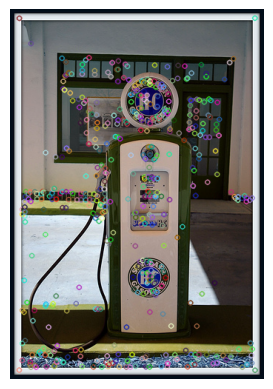

In [35]:
def detect_keypoints(image, method='SIFT'):
    if method == 'SIFT':
        # Initialize SIFT detector
        detector = cv2.SIFT_create()
    elif method == 'SURF':
        # Initialize SURF detector
        detector = cv2.xfeatures2d.SURF_create()
    elif method == 'ORB':
        # Initialize ORB detector
        detector = cv2.ORB_create()

    # Detect keypoints
    keypoints,  descriptors= detector.detectAndCompute(image, None)

    return keypoints, descriptors

def display_image(image, draw_type = 0):
    if draw_type == 0:
        plt.axis('off')
        plt.imshow(image)
    else:
        cv2.imshow('SIFT Keypoints', image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        
keypoints, descriptors = detect_keypoints(example_image, 'SIFT')

# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(example_image, keypoints, None)

# Display the image with keypoints
display_image(image_with_keypoints)

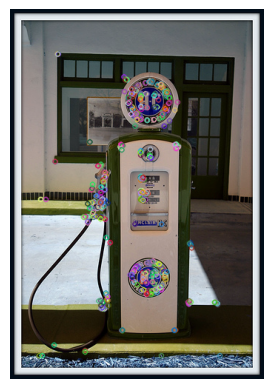

In [36]:
keypoints, descriptors = detect_keypoints(example_image, 'ORB')

# Draw keypoints on the image
image_with_keypoints = cv2.drawKeypoints(example_image, keypoints, None)

# Display the image with keypoints
display_image(image_with_keypoints)

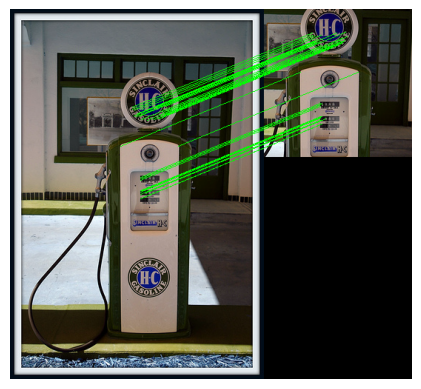

In [37]:
def feature_matching(descriptors1, descriptors2, threshold=0.75):
    # Initialize a BFMatcher
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    # Match descriptors
    matches = bf.match(descriptors1, descriptors2)

    # Filter matches based on distance threshold
    good_matches = []
    for match in matches:
        if match.distance < threshold:
            good_matches.append(match)

    return good_matches

def draw_matches(image1, keypoints1, image2, keypoints2, matches):
    # Create a new output image that concatenates the two images together
    h1, w1 = image1.shape[:2]
    h2, w2 = image2.shape[:2]
    output_image = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    output_image[:h1, :w1, :] = image1
    output_image[:h2, w1:, :] = image2

    # Draw lines between matched keypoints
    for match in matches:
        pt1 = (int(keypoints1[match.queryIdx].pt[0]), int(keypoints1[match.queryIdx].pt[1]))
        pt2 = (int(keypoints2[match.trainIdx].pt[0]) + w1, int(keypoints2[match.trainIdx].pt[1]))
        cv2.line(output_image, pt1, pt2, (0, 255, 0), 1)

    return output_image

# Read images
small_image = example_image[100:300, 100:300]

# Detect keypoints and extract descriptors
keypoints1, descriptors1 = detect_keypoints(example_image, 'ORB')
keypoints2, descriptors2 = detect_keypoints(small_image, 'ORB')

# Perform feature matching
matches = feature_matching(descriptors1, descriptors2)

# Draw matches
matched_image = draw_matches(example_image, keypoints1, small_image, keypoints2, matches)

# Display the matched image
display_image(matched_image)

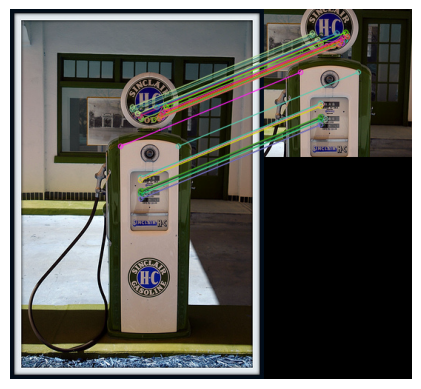

In [38]:
def draw_matches2(image1, keypoints1, image2, keypoints2, matches):
    result_image = cv2.drawMatches(
        image1, keypoints1,
        image2, keypoints2,
        matches, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    return result_image

# Draw matches
matched_image2 = draw_matches2(example_image, keypoints1, small_image, keypoints2, matches)

# Display the matched image
display_image(matched_image2)

In [25]:
# Calculates the chi-square distance between two probability distributions.
def chi_square_distance(P, Q):
    # Check if the lengths of the distributions are equal
    if len(P) != len(Q):
        raise ValueError("Probability distributions must be of the same length")
    
    # Initialize the chi-square distance
    chi_square = 0.0
    
    # Calculate the chi-square distance
    for i in range(len(P)):
        # Avoid division by zero
        if P[i] != 0:
            chi_square += ((P[i] - Q[i]) ** 2) / P[i]
    
    return chi_square

# Calculates the Euclidean distance between two vectors.
def euclidean_distance(P, Q, axis=None):
    # Convert P and Q to numpy arrays
    P = np.array(P)
    Q = np.array(Q)
    
    # Calculate the Euclidean distance
    dist = np.linalg.norm(P - Q, axis=axis)
    
    return dist

# Assigns each descriptor to its closest codeword in the codebook.
def assign_descriptors_to_codewords(descriptors: np.ndarray, codebook):
    # Reshape descriptors to make them compatible with the codebook
    descriptors_reshaped = np.reshape(descriptors, (descriptors.shape[0], 1, descriptors.shape[1]))
    
    # Calculate distances between descriptors and codebook
    distances = euclidean_distance(descriptors_reshaped, codebook, axis=2)
    
    # Get the index of the closest codeword for each descriptor
    descriptor_codeword_indices = np.argmin(distances, axis=1)
    
    return descriptor_codeword_indices

In [26]:
def bow_formation(descriptors, k):
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(descriptors)

    # Get cluster centers
    visual_dictionary = kmeans.cluster_centers_

    return visual_dictionary

def quantize_image(descriptors, visual_dictionary):
    # Initialize KMeans with the number of clusters
    kmeans = KMeans(n_clusters=len(visual_dictionary))
    
    # Fit KMeans to the visual dictionary
    kmeans.fit(visual_dictionary)
    
    # Predict the nearest cluster for each descriptor
    labels = kmeans.predict(descriptors)
    
    # Create a histogram of visual word occurrences
    histogram, _ = np.histogram(labels, bins=np.arange(len(visual_dictionary)+1))
    
    return histogram

def vectorize_image(descriptors, codebook):
    if descriptors is None:
        return None
    frequencies = np.zeros(len(codebook), dtype=np.int64)

    # Assign each descriptor to the nearest cluster centroid
    descriptor_codeword_indices = assign_descriptors_to_codewords(descriptors, codebook)

    # Count occurrences of each cluster centroid
    for indices in descriptor_codeword_indices:
        frequencies[indices] += 1

    return frequencies

def visualize_histogram(histogram, visual_dictionary):
    # Plot histogram
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(histogram)), histogram, align='center', color='skyblue')
    plt.xlabel('Visual Word Index')
    plt.ylabel('Frequency')
    plt.title('Histogram of Visual Word Occurrences')
    plt.xticks(range(len(visual_dictionary)), range(len(visual_dictionary)))
    plt.grid(True)
    plt.show()

def extract_all_keypoints(image_list, method = 'ORB'):
    descriptor_list = []
    
    for image in image_list:
        keypoints, descriptors = detect_keypoints(image, method)
        if descriptors is None:
            continue
        descriptor_list.extend(descriptors)

    return np.array(descriptor_list)

def vectorize_all_images(image_list, codebook):
    image_vectors = []

    for image in image_list:
        keypoints, descriptors = detect_keypoints(image, 'ORB')
        if descriptors is not None:
            vector = vectorize_image(descriptors, codebook)
        else:
            vector = np.zeros(len(codebook), dtype=np.int64)
        image_vectors.append(vector)
        
    return np.array(image_vectors)


def knn_classification(image_vectors, test_image_vectors, y_train, y_test, metric='euclidean'):
    # Predict using k-nearest neighbors algorithm
    x_train_vectors = image_vectors
    y_train_labels = y_train
    x_test_vectors = test_image_vectors
    y_test_labels = y_test
    
    classifier = KNeighborsClassifier(n_neighbors=5, metric=metric)
    classifier.fit(x_train_vectors, y_train_labels)
    
    y_pred = classifier.predict(x_test_vectors)
    accuracy = accuracy_score(y_test_labels, y_pred)
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    
    return accuracy, conf_mat

In [27]:
start = time.time()
test1 = [detect_keypoints(image, 'SIFT') for image in x_train]
end = time.time()
print(f"SIFT runtime: {end-start}")

start = time.time()
test2 = [detect_keypoints(image, 'ORB') for image in x_train]
end = time.time()
print(f"ORB runtime: {end-start}")

SIFT runtime: 238.3754539489746
ORB runtime: 26.318122625350952


In [28]:
# Extract descriptors from train images
all_descriptors = extract_all_keypoints(x_train)

for i in range(50,201,50):
    start = time.time()
    bow_formation(all_descriptors, i)
    end = time.time()
    print(f"Number of clusters: {i}, runtime: {end-start}")

Number of clusters: 50, runtime: 53.61097431182861
Number of clusters: 100, runtime: 91.89916229248047
Number of clusters: 150, runtime: 126.74715566635132
Number of clusters: 200, runtime: 162.94931602478027


In [32]:
y_test_cpy = y_test

for i in range(50,101,50):
    # Build the codebook
    codebook = bow_formation(all_descriptors, i)

    # Train image vectorization
    image_vectors = vectorize_all_images(x_train, codebook)

    # Test image vectorization
    test_image_vectors = vectorize_all_images(x_test, codebook)
    
    for method in [chi_square_distance, "cosine", euclidean_distance]:
        start = time.time()
        accuracy, conf_mat = knn_classification(image_vectors, test_image_vectors, y_train, y_test_cpy, method)
        end = time.time()
        print(f"Word count: {i}, Method: {method}, Runtime: {end-start}, Accuracy: {accuracy}")

TypeError: 'numpy.ndarray' object is not callable

In [ ]:
def plot_confusion_matrix(confusion_matrix, length):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=plt.xticks(np.arange(length)), yticklabels=plt.yticks(np.arange(length)))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

codebook = bow_formation(all_descriptors, 50)
image_vectors = vectorize_all_images(x_train, codebook)
test_image_vectors = vectorize_all_images(x_test, codebook)
accuracy, conf_mat = knn_classification(image_vectors, test_image_vectors, y_train, y_test, metric='euclidean')
plot_confusion_matrix(conf_mat, len(class_enums))

TypeError: 'numpy.ndarray' object is not callable